## Week 5

**MNIST classification using CNN**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines.
torch.manual_seed(2022)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2022)

**Data Loading and Pre-processing**

In [2]:
# check availability of GPU and set the device accordingly

device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Hyper parameters
num_epochs = 10
num_classes = 10
learning_rate = 0.001

# define a transforms for preparing the dataset
# for normalization of the MNIST dataset, take mean=0.1307 and std=0.3081

#### YOUR CODE STARTS HERE ####
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with the specified mean and standard deviation
])
#### YOUR CODE ENDS HERE ####

In [3]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
#### YOUR CODE ENDS HERE ####


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 891731.96it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 126942.82it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1179292.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6163225.09it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
from torch.utils.data import DataLoader

# Batch size for both training and test sets
batch_size = 32

# create dataloaders for training and test datasets
# use a batch size of 32 for training and test set and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#### YOUR CODE ENDS HERE ####

**Network Definition**

In [5]:
class ConvolutionNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvolutionNet, self).__init__()

        # Define a sequential module with:
        # 1. Conv layer with input channel as 1, output channels as 32, kernel size of 5, stride of 1, and padding 2
        # 2. 2D BatchNorm of 32 features
        # 3. ReLU activation
        # 4. 2D MaxPool with kernel size of 2 and stride of 2
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define a sequential module with:
        # 1. Conv layer with input channel as 32, output channels as 16, kernel size of 7, stride of 1, and padding 3
        # 2. 2D BatchNorm of 16 features
        # 3. ReLU activation
        # 4. 2D MaxPool with kernel size of 2 and stride of 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define a linear (dense) layer with output features corresponding to the number of classes in the dataset
        self.fc = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        # Use the sequential convolution blocks defined above
        output = self.conv_block1(x)
        output = self.conv_block2(output)

        # Flatten the output before passing it through the fully connected layer
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output



In [6]:
model = ConvolutionNet(num_classes).to(device)
model.conv_block2[0].weight.shape

torch.Size([16, 32, 7, 7])

### Question 1

What is the size of parameter matrix corresponding to convolution layer of second sequential block ?

a) 32x16x5x5 \\
b) 16x32x6x6 \\
c) 16x32x7x7 \\
d) 32x16x4x4



**Training and Inference**

In [7]:
# Define the model
#### YOUR CODE STARTS HERE ####
model = ConvolutionNet(num_classes).to(device)
#### YOUR CODE ENDS HERE ####

# Define cross-entropy loss and Adam optimizer using learning rate=learning_rate
#### YOUR CODE STARTS HERE ####
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#### YOUR CODE ENDS HERE ####

# Train the model
total_step = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        #### YOUR CODE STARTS HERE ####
        # Send the images, labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Flush out the gradients stored in the optimizer
        optimizer.zero_grad()

        # Pass the images to the model and assign the output to a variable named 'output'
        output = model(images)

        # Calculate the loss (use cross-entropy in PyTorch)
        loss = criterion(output, labels)

        # Do a backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
        #### YOUR CODE ENDS HERE ####

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        ### YOUR CODE STARTS HERE ####
        # Send the images, labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Pass the images to the model and assign the output to a variable named 'outputs'
        outputs = model(images)
        #### YOUR CODE ENDS HERE ####

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model: {:.2f} %'.format(100 * correct / total))


Epoch [1/10], Step [100/1875], Loss: 0.2694
Epoch [1/10], Step [200/1875], Loss: 0.0598
Epoch [1/10], Step [300/1875], Loss: 0.4592
Epoch [1/10], Step [400/1875], Loss: 0.0623
Epoch [1/10], Step [500/1875], Loss: 0.1016
Epoch [1/10], Step [600/1875], Loss: 0.0195
Epoch [1/10], Step [700/1875], Loss: 0.0421
Epoch [1/10], Step [800/1875], Loss: 0.0199
Epoch [1/10], Step [900/1875], Loss: 0.1595
Epoch [1/10], Step [1000/1875], Loss: 0.0270
Epoch [1/10], Step [1100/1875], Loss: 0.0054
Epoch [1/10], Step [1200/1875], Loss: 0.0663
Epoch [1/10], Step [1300/1875], Loss: 0.0493
Epoch [1/10], Step [1400/1875], Loss: 0.1053
Epoch [1/10], Step [1500/1875], Loss: 0.0083
Epoch [1/10], Step [1600/1875], Loss: 0.0112
Epoch [1/10], Step [1700/1875], Loss: 0.0069
Epoch [1/10], Step [1800/1875], Loss: 0.0800
Epoch [2/10], Step [100/1875], Loss: 0.0042
Epoch [2/10], Step [200/1875], Loss: 0.0043
Epoch [2/10], Step [300/1875], Loss: 0.0048
Epoch [2/10], Step [400/1875], Loss: 0.0334
Epoch [2/10], Step [500

### Question-2

Report the final test accuracy displayed above (Select the closest option).

a) 84% \\
b) 76% \\
c) 99% \\
d) 57%



**Fine-Tuning a pre-trained Resnet18 Model**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import numpy as np
import torch.nn.functional as F
import timeit
import unittest


In [9]:
# check availability of GPU and set the device accordingly
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 10
num_classes = 10
learning_rate = 0.001

Step 1: Load a Resnet18 pretrained model and store it in the variable 'model_res'. Also store the number of input features of **fc** layer in variable num_ftrs.

Step 2: Replace the last linear layer of Resnet18 with a Linear layer that outputs a vector of size (num_ftrs,10).

In [10]:
## Please DONOT remove these lines.
torch.manual_seed(2022)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2022)

##YOUR CODE STARTS HERE
model_res = models.resnet18(pretrained=True)
num_ftrs = model_res.fc.in_features
model_res.fc = nn.Linear(num_ftrs, 10)
##YOUR CODE ENDS HERE
model_res = model_res.cuda(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 221MB/s]


Step 3: Freeze the parameters of the layer1 and layer 2 of ResNet18 model using the 'layers' list variable

In [11]:
layers = [model_res.layer1,model_res.layer2]
##YOUR CODE STARTS HERE
for l in layers:
  for param in l.parameters():
    param.requires_grad = False
## YOUR CODE ENDS HERE

In [12]:
# define a set of transforms for preparing the dataset
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=8),
        transforms.RandomHorizontalFlip(), # flip the image horizontally (use pytorch random horizontal flip)
        transforms.ToTensor(), # convert the image to a pytorch tensor
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # normalise the images with mean and std of the dataset
        ])

# define transforms for the test data: Should they be same as the one used for train?
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

use_cuda = torch.cuda.is_available() # if you have acess to a GPU, enable it to speed the training

In [13]:
from torchvision.datasets import CIFAR10

# Load the CIFAR10 training dataset using the transform defined above
train_dataset = CIFAR10(root='./data', train=True, transform=transform_train, download=True)

# Load the CIFAR10 test dataset using the transform defined above
test_dataset = CIFAR10(root='./data', train=False, transform=transform_test, download=True)

100%|██████████| 170498071/170498071 [00:20<00:00, 8222979.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
from torch.utils.data import DataLoader

# Batch size for both training and test sets
batch_size = 32

# create dataloaders for training and test datasets
# use a batch size of 32 for training and test set and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#### YOUR CODE ENDS HERE ####

In [15]:
# Write the model definition, training and testing code exactly as before and replace model name by model_res
#### YOUR CODE STARTS HERE ####
#define cross entropy loss and Adam optimizer using learning rate=learning_rate
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_res.parameters(), lr=learning_rate)
# Train the model
total_step = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # send the images, labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Flush out the gradients stored in the optimizer
        optimizer.zero_grad()

        # Pass the images to the model and assign the output to a variable named 'output'
        output = model_res(images)

        # Calculate the loss (use cross-entropy in PyTorch)
        loss = criterion(output, labels)

        # Do a backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model_res.eval() # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        # send the image, labels to the device
        images = images.to(device)
        labels = labels.to(device)

        # Pass the images to the model and assign the output to a variable named 'outputs'
        outputs = model_res(images)
        #### YOUR CODE ENDS HERE ####

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model : {} %'.format(100 * correct / total))
#### YOUR CODE ENDS HERE ####

Epoch [1/10], Step [100/1563], Loss: 1.7505
Epoch [1/10], Step [200/1563], Loss: 1.4074
Epoch [1/10], Step [300/1563], Loss: 1.3708
Epoch [1/10], Step [400/1563], Loss: 1.3960
Epoch [1/10], Step [500/1563], Loss: 1.6107
Epoch [1/10], Step [600/1563], Loss: 1.0205
Epoch [1/10], Step [700/1563], Loss: 1.3820
Epoch [1/10], Step [800/1563], Loss: 1.4931
Epoch [1/10], Step [900/1563], Loss: 1.4771
Epoch [1/10], Step [1000/1563], Loss: 1.5143
Epoch [1/10], Step [1100/1563], Loss: 1.2520
Epoch [1/10], Step [1200/1563], Loss: 1.0401
Epoch [1/10], Step [1300/1563], Loss: 1.1296
Epoch [1/10], Step [1400/1563], Loss: 1.1254
Epoch [1/10], Step [1500/1563], Loss: 1.2765
Epoch [2/10], Step [100/1563], Loss: 1.2082
Epoch [2/10], Step [200/1563], Loss: 0.9097
Epoch [2/10], Step [300/1563], Loss: 0.7763
Epoch [2/10], Step [400/1563], Loss: 1.2824
Epoch [2/10], Step [500/1563], Loss: 1.1470
Epoch [2/10], Step [600/1563], Loss: 1.0453
Epoch [2/10], Step [700/1563], Loss: 0.9824
Epoch [2/10], Step [800/15

### Question 3
What is the test accuracy after fine tuning?(Select the closest answer)

a) 75% \\
b) 80% \\
c) 85% \\
d) 90%

## Week 6

**Saliency map using simple gradient method**

In [ ]:
#IMPORTS
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from PIL import Image
import torchvision.models as models
from torch.autograd import Variable
import seaborn as sns
import cv2


In [ ]:
#Custom function to display the image using matplotlib
def imshow(img, title):
  plt.figure(figsize = (4, 4))
  plt.axis("off")
  plt.imshow(img)
  plt.title(title)
  plt.show()

#custom function to preprocess the image
def preprocess_image(img, resize_im=True):
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(img) != Image.Image:
        try:
            img = Image.fromarray(img)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        img = img.resize((224, 224), Image.ANTIALIAS)

    im_arr = np.float32(img)
    im_arr = im_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_arr):
        im_arr[channel] /= 255
        im_arr[channel] -= mean[channel]
        im_arr[channel] /= std[channel]
    # Convert to float tensor
    im_float = torch.from_numpy(im_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_float.unsqueeze_(0)
    # Convert to Pytorch variable
    im_var = Variable(im_float, requires_grad=True)
    return im_var


In [ ]:
#importing the imagenet-pretrained vgg16 model
model = torchvision.models.vgg16(pretrained=True)

#setting the grad option to false because we do not have to train the model
for param in model.parameters():
    param.requires_grad = False

# reading the input image
img = Image.open('car.png').convert('RGB')

#calling the above defined preprocessing function
X = preprocess_image(img)

### YOUR CODE STARTS HERE ###

#we would run the model in evaluation mode
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
# find more info regarding the same here: https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html
X.requires_grad_()

#forward pass through the model to get the logit scores.
logits = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.
logits_max_index = torch.argmax(logits, dim=1)
logits_max = logits[0, logits_max_index]


#backward function on logits_max performs the backward pass in the computation graph and calculates the gradient of
#logits_max with respect to nodes in the computation graph

logits_max.backward()
### YOUR CODE ENDS HERE ###

absolute_value = torch.squeeze(X.grad.data.abs())

### YOUR CODE STARTS HERE ###

#Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
#R, G and B. Now, take the max pixel value accross each channel and take the mean of these values.
#iterating through every channel to obtain the max of each channel

max_values = []
for i in range(absolute_value.shape[0]):
  max_values.append(absolute_value[i].max())

#calculating the mean of the values obtained using the above loop
saliency_mean = sum(max_values) / len(max_values)

print("Saliency Map Mean Value:", saliency_mean)

### YOUR CODE ENDS HERE ###

<ipython-input-20-b7e9a614dc50>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


Saliency Map Mean Value: tensor(0.1094)


### Question 4:
Given a Pretrained VGG16 model, find out the mean of the maximum pixel values across each channel of the saliency map generated using the "Simple Gradient" method.

a)   Mean - 0.1094 \\
b)   Mean - 0.1121 \\
c)   Mean - 0.1258 \\
d)   Mean - 0.1248


**Occulusion experiment: We will find the difference in the bottleneck features of VGG-16 pretrained model in the presence of occulusion.**



Step 1: Create a square mask on img1 (fox image) and store it in the variable 'occ'.

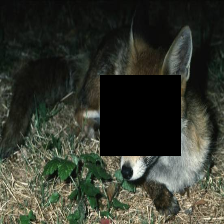

In [ ]:
img1 = cv2.imread('/content/fox.jpg')
img1 = cv2.resize(img1, (224, 224))


#make a square mask (using black pixels) on the input image with the the coordinates mentioned start height=100, start width =75,
#end height=180, end width=155

occ = cv2.rectangle(img1, (100, 75), (180, 155), (0, 0, 0), -1)


#visualising the image after masking
cv2_imshow(occ)

In [ ]:
image = Image.open('fox.jpg').convert('RGB') #Load the original fox image

Step 2: Load the pretrained VGG-16 model from torchvision and store it in 'model_vgg'.
(VGG-16 contains two main layers features and classifier). The features layer outputs after the final max pool operation as you can see from the output. This output is also called as 'Bottleneck features'.



In [ ]:
# Load the pretrained VGG-16 model
model_vgg = models.vgg16(pretrained=True)

# Print the features layer, which contains the bottleneck features
model_vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Step 3: In the function get_activation, create hook function to get the output of the bottleneck features of VGG-16.

Step 4: Forward pass the 'Original Input' into the model_vgg.

Step 5: After step 4, bottleneck features are stored in activation dictionary. Store the the original bottleneck features in the variable 'bottleneck_org'.

Step 6: Forward pass 'Occ Input' into the model_vgg.

Step 7: After step 6, bottleneck features are stored in activation dictionary. Store the the occ bottleneck features in the variable 'bottleneck_oc'.

Please see below documentation for hints

https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html

In [ ]:
original_input = preprocess_image(image)
occ_input = preprocess_image(occ)

<ipython-input-40-b7e9a614dc50>:24: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)


In [ ]:
model_vgg.eval()

activation = {}

def get_activation(name):
  ##YOUR CODE STARTS HERE
    def hook(model, input, output):
        activation[name] = output
    return hook
  ## YOUR CODE ENDS HERE

model_vgg.features.register_forward_hook(get_activation('features'))

##YOUR CODE STARTS HERE
model_vgg(original_input)
## YOUR CODE ENDS HERE
bottleneck_org = activation['features']


##YOUR CODE STARTS HERE
model_vgg(occ_input)
## YOUR CODE ENDS HERE

bottleneck_occ = activation['features']


In [ ]:
print((bottleneck_org-bottleneck_occ).mean())

tensor(0.1169, grad_fn=<MeanBackward0>)


### Question 5:
The mean of the difference between Original bottleneck layers and Occuluded bottleneck layers? (The output of the above print statement)

a) 0.1169 \\
b) -0.1169 \\
c) 0.2014 \\
d) -0.2014

**Class Attribution Map (CAM) calculation.**

In [ ]:
## DO NOT CHANGE
torch.manual_seed(2022)
conv_feature = torch.randn((1,512,7,7))
wts=torch.rand((10,512))

We will define a function CAM() that returns CAM maps given the convolution features and the weights

Step 1: Define a for loop for each element in the 'cls_list' variable.

Step 2: Create an empty list named 'output_cam'

Step 3: Resize the conv_feature tensor into shape (channels, h*w) and store it in the variable resize_feature

Step 4: Calculate the matrix multiplication of the wts matrix for a particular class and the resize_feature variable and store it in the variable 'cam'.

Step 5: Reshape cam variable into shape (h,w) and store it in the vairable 'cam'

In [ ]:
def CAM(conv_feature, wts,cls_list):
    """
    arguments:
    conv_feature: the feature maps of the last convolutional layer
    wts: the weights that have been extracted from the trained parameters
    """
    up_shape = (224, 224)
    batch_size, channels, h, w = conv_feature.shape
    ## YOUR CODE STARTS HERE##
    for idx in cls_list:
      output_cam = []
      resize_feature = conv_feature[0].reshape(channels, h * w)
      cam = torch.mm(wts[idx].unsqueeze(0), resize_feature)
      cam = cam.reshape(h, w)
      ## YOUR CODE ENDS HERE##
      cam = cam - torch.min(cam)
      cam_img = cam / torch.max(cam)
      cam_img = np.uint8(255 * cam_img)
      output_cam.append(cv2.resize(cam_img, up_shape))
    return output_cam

Mean value of the attribution map: 110.38111846301021


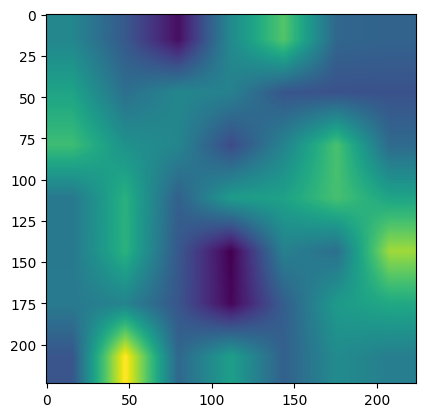

In [ ]:
CAM = CAM(conv_feature,wts,[6])
plt.imshow(CAM[0])
print("Mean value of the attribution map: "+str(CAM[0].mean()))

### Question 6:
What is the mean value of the attribution map for class 6? (Selected the closest option)

a) 50 \\
b) 100 \\
c) 150  
d) 200